<a href="https://colab.research.google.com/github/Wonny0120/portfolio/blob/main/bikesNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

mini=pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv")

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [2]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112475 entries, 0 to 112474
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   dteday        112475 non-null  object 
 1   hr            112475 non-null  float64
 2   casual        112475 non-null  int64  
 3   registered    112475 non-null  int64  
 4   temp_c        112475 non-null  float64
 5   feels_like_c  112475 non-null  float64
 6   hum           112475 non-null  float64
 7   windspeed     112475 non-null  float64
 8   weathersit    112475 non-null  int64  
 9   season        112475 non-null  int64  
 10  holiday       112475 non-null  int64  
 11  workingday    112475 non-null  int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 10.3+ MB


In [3]:
bikes["dteday"] = pd.to_datetime(bikes["dteday"])

bikes["year"] = bikes["dteday"].dt.year
bikes["month"] = bikes["dteday"].dt.month
bikes["day"] = bikes["dteday"].dt.day
bikes["dayofweek"] = bikes["dteday"].dt.dayofweek

In [4]:
bikes["is_rush_hour"] = bikes["hr"].isin([7,8,9,16,17,18]).astype(int)
bikes["is_weekend"] = (bikes["workingday"] == 0).astype(int)
bikes["temp_diff"] = bikes["feels_like_c"] - bikes["temp_c"]

In [5]:
bikes["temp_hr"] = bikes["temp_c"] * bikes["hr"]
bikes["rush_work"] = bikes["is_rush_hour"] * bikes["workingday"]
bikes["temp_hum"] = bikes["temp_c"] * bikes["hum"]

In [6]:
bikes['Total_users']=bikes['casual']+bikes['registered']

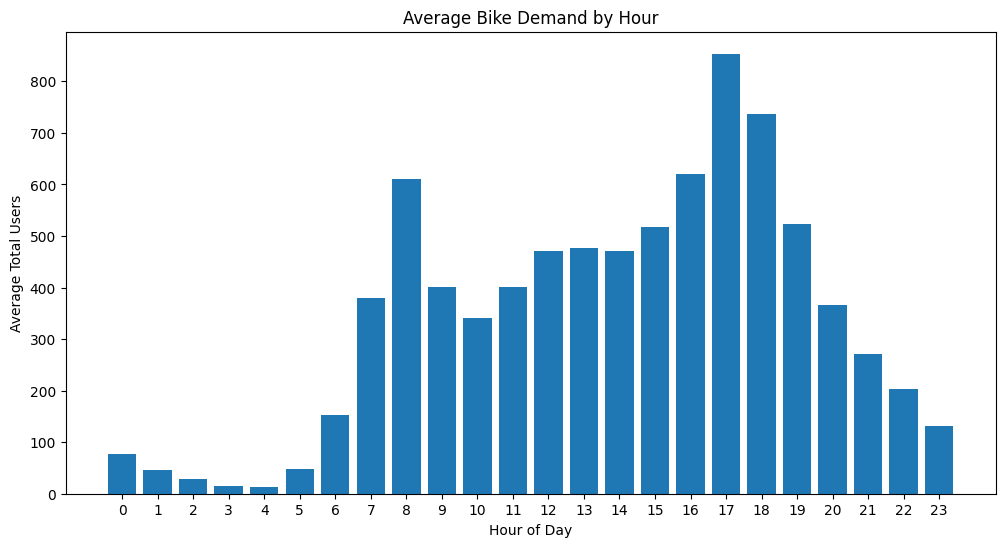

In [7]:
hourly_avg = bikes.groupby("hr")["Total_users"].mean().reset_index()

plt.figure(figsize=(12,6))
plt.bar(hourly_avg["hr"], hourly_avg["Total_users"])
plt.title("Average Bike Demand by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Total Users")
plt.xticks(range(0,24))
plt.show()

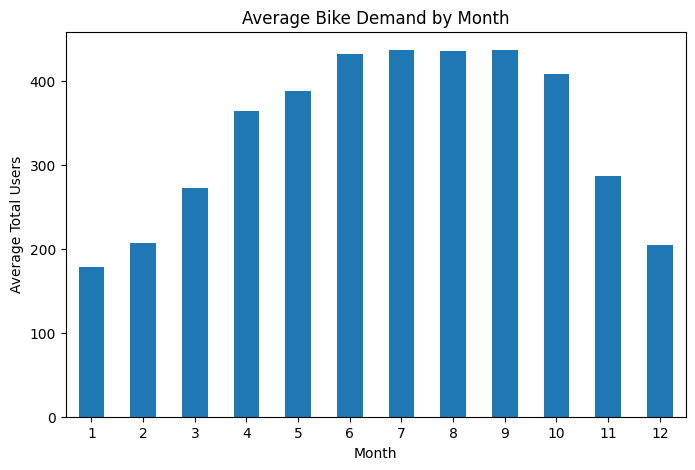

In [8]:
monthly_avg= bikes.groupby("month")["Total_users"].mean()

plt.figure(figsize=(8,5))
monthly_avg.plot(kind="bar")

plt.title("Average Bike Demand by Month")
plt.xlabel("Month")
plt.ylabel("Average Total Users")
plt.xticks(rotation=0)
plt.show()

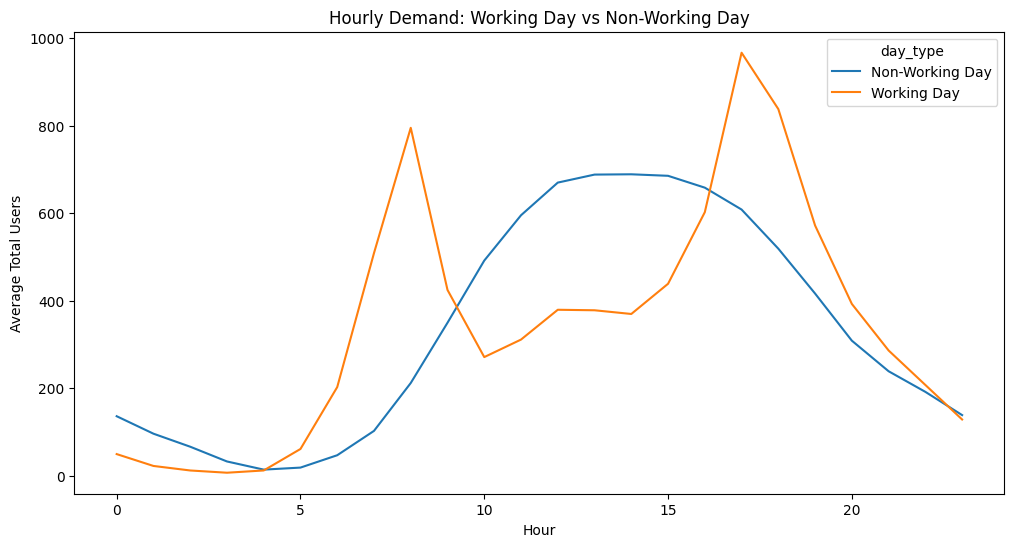

In [28]:
hourly_work = bikes.groupby(["hr","workingday"])["Total_users"].mean().reset_index()
hourly_work["day_type"] = hourly_work["workingday"].map({
    0: "Non-Working Day",
    1: "Working Day"
})

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_work, x="hr", y="Total_users", hue="day_type")
plt.title("Hourly Demand: Working Day vs Non-Working Day")
plt.xlabel("Hour")
plt.ylabel("Average Total Users")

plt.show()

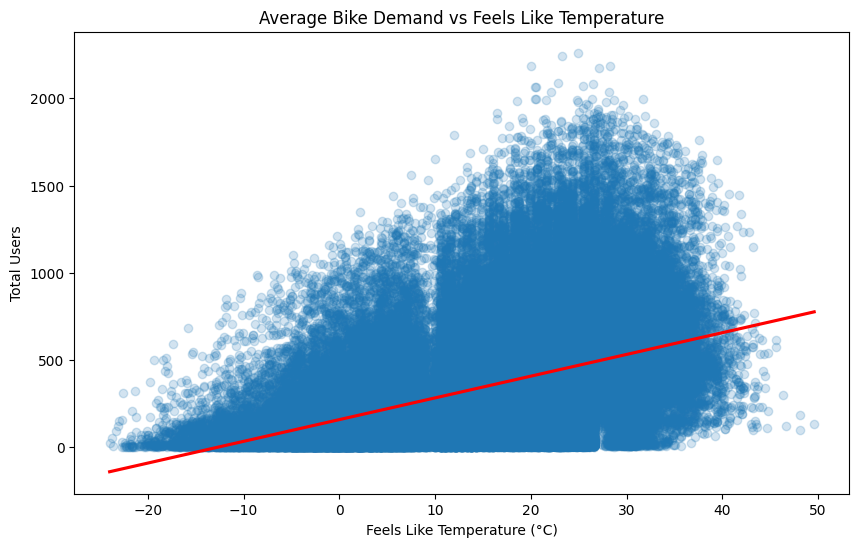

In [29]:
plt.figure(figsize=(10,6))

sns.regplot(
    data=bikes,
    x="feels_like_c",
    y="Total_users",
    scatter_kws={"alpha":0.2},
    line_kws={"color":"red"}
)

plt.title("Average Bike Demand vs Feels Like Temperature")
plt.xlabel("Feels Like Temperature (°C)")
plt.ylabel("Total Users")
plt.show()

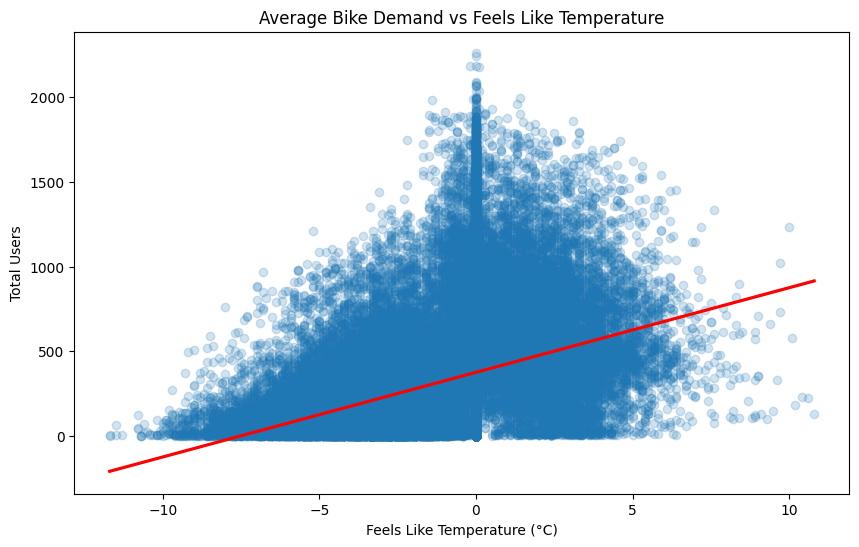

In [30]:
plt.figure(figsize=(10,6))

sns.regplot(
    data=bikes,
    x="temp_diff",
    y="Total_users",
    scatter_kws={"alpha":0.2},
    line_kws={"color":"red"}
)

plt.title("Average Bike Demand vs Feels Like Temperature")
plt.xlabel("Feels Like Temperature (°C)")
plt.ylabel("Total Users")
plt.show()

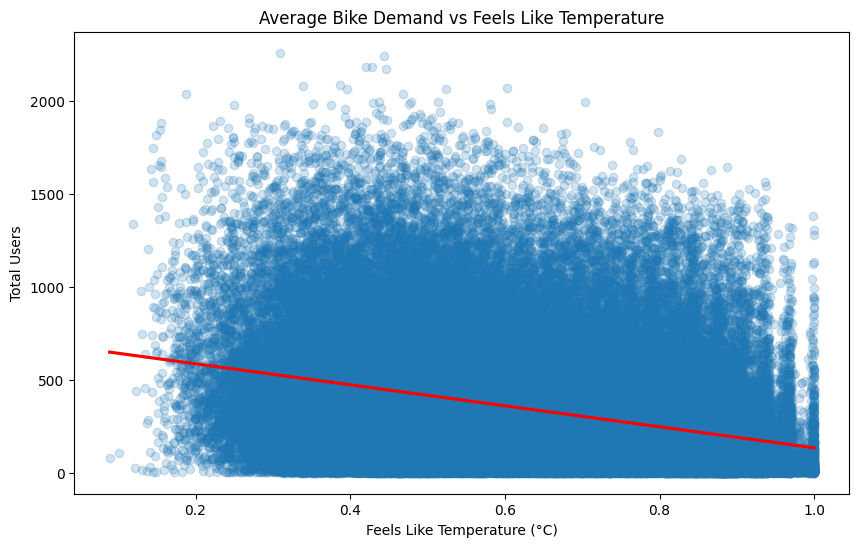

In [33]:
plt.figure(figsize=(10,6))

sns.regplot(
    data=bikes,
    x="hum",
    y="Total_users",
    scatter_kws={"alpha":0.2},
    line_kws={"color":"red"}
)

plt.title("Average Bike Demand vs Feels Like Temperature")
plt.xlabel("Feels Like Temperature (°C)")
plt.ylabel("Total Users")
plt.show()

In [10]:
model = pd.get_dummies(
    bikes,
    columns=["season", "weathersit", "hr", "holiday", "workingday"],
    drop_first=True
)

In [11]:
X=bikes.drop(columns=['Total_users', 'casual','registered','dteday'])
y=bikes['Total_users']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = norm.transform(X_train)

# transform testing dataabs
X_test = norm.transform(X_test)

In [14]:
nn_tuned = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(64, activation="relu"),

    layers.Dense(1)
])

nn_tuned.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

In [15]:
early_stop = keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True
)

In [16]:
history_tuned = nn_tuned.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=256,
    callbacks=[early_stop],
    verbose=0
)

In [17]:
y_pred = nn_tuned.predict(X_test).flatten()

rmse_nn_tuned = (root_mean_squared_error(y_test, y_pred))
r2_nn_tuned = r2_score(y_test, y_pred)

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
predictions=np.round(nn_tuned.predict(X_test),1)

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [19]:
rmse_nn_tuned

77.24303436279297

In [20]:
r2_nn_tuned

0.9492473602294922

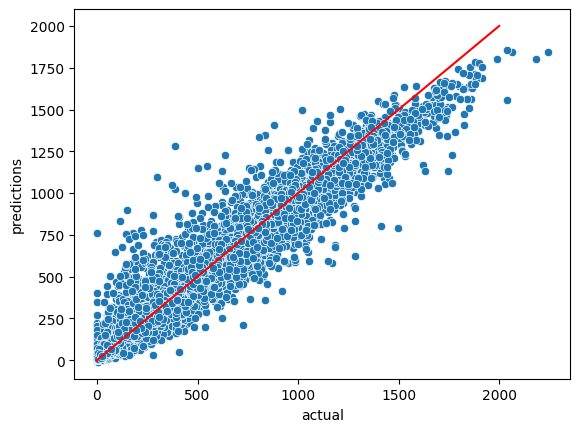

In [21]:
pred = pd.DataFrame(predictions,columns=['predictions'])
pred
pred['actual'] = y_test.tolist()
pred

pred['difference'] = pred['actual']-pred['predictions']
pred

import seaborn as sns
xlims =(0,2000)
ax = sns.scatterplot(data=pred,x='actual',y='predictions')
ax.plot(xlims,xlims, color='r')
plt.show()

In [22]:
mini["dteday"] = pd.to_datetime(mini["dteday"])

mini["year"] = mini["dteday"].dt.year
mini["month"] = mini["dteday"].dt.month
mini["day"] = mini["dteday"].dt.day
mini["dayofweek"] = mini["dteday"].dt.dayofweek

mini = mini.drop(columns=["dteday"])

mini["is_rush_hour"] = mini["hr"].isin([7,8,9,16,17,18]).astype(int)
mini["is_weekend"] = (mini["workingday"] == 0).astype(int)
mini["temp_diff"] = mini["feels_like_c"] - mini["temp_c"]

bikes["temp_hr"] = bikes["temp_c"] * bikes["hr"]
bikes["rush_work"] = bikes["is_rush_hour"] * bikes["workingday"]
bikes["temp_hum"] = bikes["temp_c"] * bikes["hum"]

In [23]:
mini_scaled = norm.transform(mini)
mini_pred_nn = nn_tuned.predict(mini_scaled).flatten()

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- rush_work
- temp_hr
- temp_hum


In [ ]:
mini["predicted_total_users"] = mini_pred_nn
#mini.to_csv("mini_holdout_predictions.csv", index=False)

In [ ]:
y_pred = nn_tuned.predict(X_test).flatten()